In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch torchvision transformers numpy pillow tqdm pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 45.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Computer Vision/Final-CV/sd')

# Import các module từ code của bạn
import torch
import os
from clip import CLIP
from encoder import VAE_Encoder
from decoder import VAE_Decoder
from diffusion import Diffusion
from model_converter import load_from_standard_weights
from model_loader import preload_models_from_standard_weights
from pipeline import generate
from transformers import CLIPTokenizer
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

# Thiết lập thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Thiết bị: {DEVICE}")

# Đường dẫn dữ liệu và code
DATA_DIR = "/content/drive/MyDrive/Computer Vision/Final-CV/data"
CODE_DIR = "/content/drive/MyDrive/Computer Vision/Final-CV/sd"
CHECKPOINT_PATH = "/content/drive/MyDrive/Computer Vision/Final-CV/data/v1-5-pruned-emaonly.ckpt"
OUTPUT_DIR = "/content/drive/MyDrive/Computer Vision/Final-CV/output"
MODEL_DIR = "/content/drive/MyDrive/Computer Vision/Final-CV/models"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

Thiết bị: cpu


In [ ]:
# Tiền xử lý dữ liệu
def load_prompt_image_pairs(prompt_file, image_dir):
    with open(prompt_file, "r") as f:
        prompts = [line.strip() for line in f if line.strip()]

    image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]
    image_map = {}
    for f in image_files:
        match = re.search(r"_(\d+)\.jpg", f)
        if match:
            idx = int(match.group(1))
            image_map[idx] = f

    pairs = []
    for i, prompt in enumerate(prompts):
        # Giả sử prompt dòng i tương ứng với ảnh có số thứ tự i
        # Thay đổi logic này nếu ánh xạ khác
        idx = i
        if idx in image_map:
            pairs.append((prompt, os.path.join(image_dir, image_map[idx])))

    print(f"Số cặp prompt-ảnh: {len(pairs)}")
    return pairs

In [ ]:
# Tạo Dataset
from torch.utils.data import Dataset
from PIL import Image
class SoftDrinkLabelDataset(Dataset):
    def __init__(self, prompt_image_pairs, transform=None):
        self.pairs = prompt_image_pairs
        self.transform = transform

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        _, image_path = self.pairs[idx]
        img = Image.open(image_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
import gc
import numpy as np
from torch.cuda.amp import GradScaler, autocast

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Transform để chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu train
train_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "train/prompts1.txt"),
    os.path.join(DATA_DIR, "train/images")
)
train_dataset = SoftDrinkLabelDataset(train_pairs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# Tải dữ liệu test
test_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "test/prompts1.txt"),
    os.path.join(DATA_DIR, "test/images")
)
test_dataset = SoftDrinkLabelDataset(test_pairs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

# Tải mô hình
models = preload_models_from_standard_weights(CHECKPOINT_PATH, DEVICE)
encoder = models["encoder"].to(DEVICE)
decoder = models["decoder"].to(DEVICE)
encoder.train()
decoder.train()

# Thiết lập optimizer và loss
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)
criterion = torch.nn.MSELoss()
scaler = GradScaler()

# Hàm tính SSIM và PSNR
def compute_metrics(reconstructed, images):
    reconstructed = reconstructed.cpu().detach().numpy().transpose(0, 2, 3, 1)
    images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)
    ssim_scores = []
    psnr_scores = []
    for i in range(reconstructed.shape[0]):
        recon_img = (reconstructed[i] * 0.5 + 0.5).clip(0, 1)
        orig_img = (images[i] * 0.5 + 0.5).clip(0, 1)
        ssim_score = ssim(recon_img, orig_img, channel_axis=2, data_range=1.0)
        psnr_score = psnr(recon_img, orig_img, data_range=1.0)
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
    return np.mean(ssim_scores), np.mean(psnr_scores)

# Huấn luyện VAE và lưu mô hình mỗi epoch
num_epochs = 3
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    total_train_loss = 0
    total_ssim = 0
    total_psnr = 0
    ssim_count = 0
    for i, images in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
        images = images.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

        # Tính SSIM/PSNR mỗi 100 batch
        if i % 100 == 0:
            ssim_score, psnr_score = compute_metrics(reconstructed, images)
            total_ssim += ssim_score
            total_psnr += psnr_score
            ssim_count += 1

    # These lines should be inside the epoch loop
    avg_train_loss = total_train_loss / len(train_loader)
    avg_ssim = total_ssim / max(ssim_count, 1)
    avg_psnr = total_psnr / max(ssim_count, 1)

    # Validation
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    max_val_batches = 100  # Chỉ dùng 100 ảnh test
    with torch.no_grad():
        for i, images in enumerate(tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")):
            if i >= max_val_batches:
                break
            images = images.to(DEVICE)
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / min(max_val_batches, len(test_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}")

    # Lưu mô hình sau mỗi epoch
    encoder_path = os.path.join(MODEL_DIR, f"encoder_finetuned_epoch_{epoch+1}.pth")
    decoder_path = os.path.join(MODEL_DIR, f"decoder_finetuned_epoch_{epoch+1}.pth")
    torch.save(encoder.state_dict(), encoder_path)
    torch.save(decoder.state_dict(), decoder_path)
    print(f"Đã lưu mô hình: {encoder_path}, {decoder_path}")

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

Số cặp prompt-ảnh: 2141
Số cặp prompt-ảnh: 119


<ipython-input-9-66191f4f6ea3>:51: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/3 (Train):   0%|          | 0/2141 [00:00<?, ?it/s]<ipython-input-9-66191f4f6ea3>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/3 (Validation):  84%|████████▍ | 100/119 [01:44<00:19,  1.05s/it]


Epoch 1/3, Train Loss: 0.0035, Val Loss: 0.0027, SSIM: 0.9153, PSNR: 32.0397
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_1.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_1.pth


Epoch 2/3 (Validation):  84%|████████▍ | 100/119 [01:12<00:13,  1.37it/s]


Epoch 2/3, Train Loss: 0.0031, Val Loss: 0.0021, SSIM: 0.9266, PSNR: 33.2815
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_2.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_2.pth


Epoch 3/3 (Validation):  84%|████████▍ | 100/119 [01:12<00:13,  1.37it/s]


Epoch 3/3, Train Loss: 0.0023, Val Loss: 0.0023, SSIM: 0.9276, PSNR: 33.9262
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_3.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_3.pth


# tiếp tục train

In [ ]:
import os
import gc
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.amp import GradScaler, autocast
import re
# from skimage.metrics import ssim, psnr # Remove this line

# Thiết lập môi trường để tối ưu bộ nhớ
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Transform để chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu train
train_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "train/prompts1.txt"),
    os.path.join(DATA_DIR, "train/images")
)
train_dataset = SoftDrinkLabelDataset(train_pairs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# Tải dữ liệu test
test_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "test/prompts1.txt"),
    os.path.join(DATA_DIR, "test/images")
)
test_dataset = SoftDrinkLabelDataset(test_pairs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

# Tải mô hình
models = preload_models_from_standard_weights(CHECKPOINT_PATH, DEVICE)
encoder = models["encoder"].to(DEVICE)
decoder = models["decoder"].to(DEVICE)

# Thiết lập optimizer và loss
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)
criterion = torch.nn.MSELoss()
scaler = GradScaler('cuda')  # Sử dụng API mới

# Hàm tính SSIM và PSNR
# The ssim and psnr functions are already imported and available from a previous cell
def compute_metrics(reconstructed, images):
    reconstructed = reconstructed.cpu().detach().numpy().transpose(0, 2, 3, 1)
    images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)
    ssim_scores = []
    psnr_scores = []
    for i in range(reconstructed.shape[0]):
        recon_img = (reconstructed[i] * 0.5 + 0.5).clip(0, 1)
        orig_img = (images[i] * 0.5 + 0.5).clip(0, 1)
        # Use the already imported ssim and psnr functions
        ssim_score = ssim(recon_img, orig_img, channel_axis=2, data_range=1.0)
        psnr_score = psnr(recon_img, orig_img, data_range=1.0)
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
    return np.mean(ssim_scores), np.mean(psnr_scores)

# Hàm load checkpoint
def load_checkpoint(encoder, decoder, optimizer, scaler, checkpoint_dir, epoch):
    encoder_path = os.path.join(checkpoint_dir, f"encoder_finetuned_epoch_{epoch}.pth")
    decoder_path = os.path.join(checkpoint_dir, f"decoder_finetuned_epoch_{epoch}.pth")
    optimizer_path = os.path.join(checkpoint_dir, f"optimizer_finetuned_epoch_{epoch}.pth")
    scaler_path = os.path.join(checkpoint_dir, f"scaler_finetuned_epoch_{epoch}.pth")

    try:
        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Checkpoint files for epoch {epoch} not found")
        encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
        decoder.load_state_dict(torch.load(decoder_path, map_location=DEVICE))

        # Load optimizer và scaler nếu có
        if os.path.exists(optimizer_path):
            optimizer.load_state_dict(torch.load(optimizer_path, map_location=DEVICE))
        if os.path.exists(scaler_path):
            scaler.load_state_dict(torch.load(scaler_path))
        print(f"Loaded checkpoint from epoch {epoch}")
        return True
    except Exception as e:
        print(f"Error loading checkpoint for epoch {epoch}: {e}")
        return False

# Huấn luyện VAE
num_epochs = 6  # Tổng số epoch muốn chạy
start_epoch = 3  # Tiếp tục từ epoch 3

# Load checkpoint từ epoch 3
if not load_checkpoint(encoder, decoder, optimizer, scaler, MODEL_DIR, start_epoch):
    print(f"Failed to load checkpoint, starting from scratch")
    start_epoch = 0

encoder.train()
decoder.train()

for epoch in range(start_epoch, num_epochs):
    total_train_loss = 0
    total_ssim = 0
    total_psnr = 0
    ssim_count = 0
    for i, images in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
        images = images.to(DEVICE)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):  # Sử dụng API mới
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

        # Tính SSIM/PSNR mỗi 100 batch
        if i % 100 == 0:
            ssim_score, psnr_score = compute_metrics(reconstructed, images)
            total_ssim += ssim_score
            total_psnr += psnr_score
            ssim_count += 1

    avg_train_loss = total_train_loss / len(train_loader)
    avg_ssim = total_ssim / max(ssim_count, 1)
    avg_psnr = total_psnr / max(ssim_count, 1)

    # Validation
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    max_val_batches = 100  # Chỉ dùng 100 ảnh test
    with torch.no_grad():
        for i, images in enumerate(tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")):
            if i >= max_val_batches:
                break
            images = images.to(DEVICE)
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / min(max_val_batches, len(test_loader))

    # Lưu mô hình sau mỗi epoch
    try:
        encoder_path = os.path.join(MODEL_DIR, f"encoder_finetuned_epoch_{epoch+1}.pth")
        decoder_path = os.path.join(MODEL_DIR, f"decoder_finetuned_epoch_{epoch+1}.pth")
        optimizer_path = os.path.join(MODEL_DIR, f"optimizer_finetuned_epoch_{epoch+1}.pth")
        scaler_path = os.path.join(MODEL_DIR, f"scaler_finetuned_epoch_{epoch+1}.pth")

        torch.save(encoder.state_dict(), encoder_path)
        torch.save(decoder.state_dict(), decoder_path)
        torch.save(optimizer.state_dict(), optimizer_path)
        torch.save(scaler.state_dict(), scaler_path)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}")
        print(f"Đã lưu mô hình: {encoder_path}, {decoder_path}")
    except Exception as e:
        print(f"Error saving checkpoint for epoch {epoch+1}: {e}")
        print("Continuing to next epoch...")

# Lưu mô hình cuối cùng
try:
    torch.save(encoder.state_dict(), os.path.join(MODEL_DIR, "encoder_finetuned_final.pth"))
    torch.save(decoder.state_dict(), os.path.join(MODEL_DIR, "decoder_finetuned_final.pth"))
    print("Đã lưu mô hình tinh chỉnh cuối cùng")
except Exception as e:
    print(f"Error saving final model: {e}")

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

Số cặp prompt-ảnh: 2141
Số cặp prompt-ảnh: 119
Loaded checkpoint from epoch 3


Epoch 4/6 (Validation):  84%|████████▍ | 100/119 [02:16<00:25,  1.37s/it]


Epoch 4/6, Train Loss: 0.0024, Val Loss: 0.0019, SSIM: 0.9366, PSNR: 33.8424
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_4.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_4.pth


Epoch 5/6 (Validation):  84%|████████▍ | 100/119 [01:12<00:13,  1.38it/s]


Epoch 5/6, Train Loss: 0.0023, Val Loss: 0.0024, SSIM: 0.9322, PSNR: 33.6163
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_5.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_5.pth


Epoch 6/6 (Train):  28%|██▊       | 599/2141 [09:07<23:26,  1.10it/s]

In [ ]:
import os
import gc
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.amp import GradScaler, autocast
import re
# from skimage.metrics import ssim, psnr # Remove this line

# Thiết lập môi trường để tối ưu bộ nhớ
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Transform để chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu train
train_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "train/prompts1.txt"),
    os.path.join(DATA_DIR, "train/images")
)
train_dataset = SoftDrinkLabelDataset(train_pairs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# Tải dữ liệu test
test_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "test/prompts1.txt"),
    os.path.join(DATA_DIR, "test/images")
)
test_dataset = SoftDrinkLabelDataset(test_pairs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

# Tải mô hình
models = preload_models_from_standard_weights(CHECKPOINT_PATH, DEVICE)
encoder = models["encoder"].to(DEVICE)
decoder = models["decoder"].to(DEVICE)

# Thiết lập optimizer và loss
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)
criterion = torch.nn.MSELoss()
scaler = GradScaler('cuda')  # Sử dụng API mới

# Hàm tính SSIM và PSNR
# The ssim and psnr functions are already imported and available from a previous cell
def compute_metrics(reconstructed, images):
    reconstructed = reconstructed.cpu().detach().numpy().transpose(0, 2, 3, 1)
    images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)
    ssim_scores = []
    psnr_scores = []
    for i in range(reconstructed.shape[0]):
        recon_img = (reconstructed[i] * 0.5 + 0.5).clip(0, 1)
        orig_img = (images[i] * 0.5 + 0.5).clip(0, 1)
        # Use the already imported ssim and psnr functions
        ssim_score = ssim(recon_img, orig_img, channel_axis=2, data_range=1.0)
        psnr_score = psnr(recon_img, orig_img, data_range=1.0)
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
    return np.mean(ssim_scores), np.mean(psnr_scores)

# Hàm load checkpoint
def load_checkpoint(encoder, decoder, optimizer, scaler, checkpoint_dir, epoch):
    encoder_path = os.path.join(checkpoint_dir, f"encoder_finetuned_epoch_{epoch}.pth")
    decoder_path = os.path.join(checkpoint_dir, f"decoder_finetuned_epoch_{epoch}.pth")
    optimizer_path = os.path.join(checkpoint_dir, f"optimizer_finetuned_epoch_{epoch}.pth")
    scaler_path = os.path.join(checkpoint_dir, f"scaler_finetuned_epoch_{epoch}.pth")

    try:
        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Checkpoint files for epoch {epoch} not found")
        encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
        decoder.load_state_dict(torch.load(decoder_path, map_location=DEVICE))

        # Load optimizer và scaler nếu có
        if os.path.exists(optimizer_path):
            optimizer.load_state_dict(torch.load(optimizer_path, map_location=DEVICE))
        if os.path.exists(scaler_path):
            scaler.load_state_dict(torch.load(scaler_path))
        print(f"Loaded checkpoint from epoch {epoch}")
        return True
    except Exception as e:
        print(f"Error loading checkpoint for epoch {epoch}: {e}")
        return False

# Huấn luyện VAE
num_epochs = 15  # Tổng số epoch muốn chạy
start_epoch = 8  # Tiếp tục từ epoch 8

# Load checkpoint từ epoch 8
if not load_checkpoint(encoder, decoder, optimizer, scaler, MODEL_DIR, start_epoch):
    print(f"Failed to load checkpoint, starting from scratch")
    start_epoch = 0

encoder.train()
decoder.train()

for epoch in range(start_epoch, num_epochs):
    total_train_loss = 0
    total_ssim = 0
    total_psnr = 0
    ssim_count = 0
    for i, images in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
        images = images.to(DEVICE)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):  # Sử dụng API mới
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

        # Tính SSIM/PSNR mỗi 100 batch
        if i % 100 == 0:
            ssim_score, psnr_score = compute_metrics(reconstructed, images)
            total_ssim += ssim_score
            total_psnr += psnr_score
            ssim_count += 1

    avg_train_loss = total_train_loss / len(train_loader)
    avg_ssim = total_ssim / max(ssim_count, 1)
    avg_psnr = total_psnr / max(ssim_count, 1)

    # Validation
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    max_val_batches = 100  # Chỉ dùng 100 ảnh test
    with torch.no_grad():
        for i, images in enumerate(tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")):
            if i >= max_val_batches:
                break
            images = images.to(DEVICE)
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / min(max_val_batches, len(test_loader))

    # Lưu mô hình sau mỗi epoch
    try:
        encoder_path = os.path.join(MODEL_DIR, f"encoder_finetuned_epoch_{epoch+1}.pth")
        decoder_path = os.path.join(MODEL_DIR, f"decoder_finetuned_epoch_{epoch+1}.pth")
        optimizer_path = os.path.join(MODEL_DIR, f"optimizer_finetuned_epoch_{epoch+1}.pth")
        scaler_path = os.path.join(MODEL_DIR, f"scaler_finetuned_epoch_{epoch+1}.pth")

        torch.save(encoder.state_dict(), encoder_path)
        torch.save(decoder.state_dict(), decoder_path)
        torch.save(optimizer.state_dict(), optimizer_path)
        torch.save(scaler.state_dict(), scaler_path)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}")
        print(f"Đã lưu mô hình: {encoder_path}, {decoder_path}")
    except Exception as e:
        print(f"Error saving checkpoint for epoch {epoch+1}: {e}")
        print("Continuing to next epoch...")

# Lưu mô hình cuối cùng
try:
    torch.save(encoder.state_dict(), os.path.join(MODEL_DIR, "encoder_finetuned_final1.pth"))
    torch.save(decoder.state_dict(), os.path.join(MODEL_DIR, "decoder_finetuned_final1.pth"))
    print("Đã lưu mô hình tinh chỉnh cuối cùng")
except Exception as e:
    print(f"Error saving final model: {e}")

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

Số cặp prompt-ảnh: 2141
Số cặp prompt-ảnh: 119


<ipython-input-6-ece2287bc8cb>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
<ipython-input-6-ece2

Loaded checkpoint from epoch 5


Epoch 6/8 (Validation):  84%|████████▍ | 100/119 [02:42<00:30,  1.62s/it]


Epoch 6/8, Train Loss: 0.0019, Val Loss: 0.0046, SSIM: 0.9361, PSNR: 35.0566
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_6.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_6.pth


Epoch 7/8 (Validation):  84%|████████▍ | 100/119 [01:13<00:13,  1.37it/s]


Epoch 7/8, Train Loss: 0.0019, Val Loss: 0.0018, SSIM: 0.9247, PSNR: 35.1867
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_7.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_7.pth


Epoch 8/8 (Validation):  84%|████████▍ | 100/119 [01:12<00:13,  1.37it/s]


Epoch 8/8, Train Loss: 0.0019, Val Loss: 0.0022, SSIM: 0.9330, PSNR: 34.1900
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_8.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_8.pth
Đã lưu mô hình tinh chỉnh cuối cùng


In [ ]:
import os
import gc
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.amp import GradScaler, autocast
import re
# from skimage.metrics import ssim, psnr # Remove this line

# Thiết lập môi trường để tối ưu bộ nhớ
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Transform để chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu train
train_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "train/prompts1.txt"),
    os.path.join(DATA_DIR, "train/images")
)
train_dataset = SoftDrinkLabelDataset(train_pairs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# Tải dữ liệu test
test_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "test/prompts1.txt"),
    os.path.join(DATA_DIR, "test/images")
)
test_dataset = SoftDrinkLabelDataset(test_pairs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

# Tải mô hình
models = preload_models_from_standard_weights(CHECKPOINT_PATH, DEVICE)
encoder = models["encoder"].to(DEVICE)
decoder = models["decoder"].to(DEVICE)

# Thiết lập optimizer và loss
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()),
    lr=1e-4
)
criterion = torch.nn.MSELoss()
scaler = GradScaler('cuda')  # Sử dụng API mới

# Hàm tính SSIM và PSNR
# The ssim and psnr functions are already imported and available from a previous cell
def compute_metrics(reconstructed, images):
    reconstructed = reconstructed.cpu().detach().numpy().transpose(0, 2, 3, 1)
    images = images.cpu().detach().numpy().transpose(0, 2, 3, 1)
    ssim_scores = []
    psnr_scores = []
    for i in range(reconstructed.shape[0]):
        recon_img = (reconstructed[i] * 0.5 + 0.5).clip(0, 1)
        orig_img = (images[i] * 0.5 + 0.5).clip(0, 1)
        # Use the already imported ssim and psnr functions
        ssim_score = ssim(recon_img, orig_img, channel_axis=2, data_range=1.0)
        psnr_score = psnr(recon_img, orig_img, data_range=1.0)
        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
    return np.mean(ssim_scores), np.mean(psnr_scores)

# Hàm load checkpoint
def load_checkpoint(encoder, decoder, optimizer, scaler, checkpoint_dir, epoch):
    encoder_path = os.path.join(checkpoint_dir, f"encoder_finetuned_epoch_{epoch}.pth")
    decoder_path = os.path.join(checkpoint_dir, f"decoder_finetuned_epoch_{epoch}.pth")
    optimizer_path = os.path.join(checkpoint_dir, f"optimizer_finetuned_epoch_{epoch}.pth")
    scaler_path = os.path.join(checkpoint_dir, f"scaler_finetuned_epoch_{epoch}.pth")

    try:
        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Checkpoint files for epoch {epoch} not found")
        encoder.load_state_dict(torch.load(encoder_path, map_location=DEVICE))
        decoder.load_state_dict(torch.load(decoder_path, map_location=DEVICE))

        # Load optimizer và scaler nếu có
        if os.path.exists(optimizer_path):
            optimizer.load_state_dict(torch.load(optimizer_path, map_location=DEVICE))
        if os.path.exists(scaler_path):
            scaler.load_state_dict(torch.load(scaler_path))
        print(f"Loaded checkpoint from epoch {epoch}")
        return True
    except Exception as e:
        print(f"Error loading checkpoint for epoch {epoch}: {e}")
        return False

# Huấn luyện VAE
num_epochs = 15  # Tổng số epoch muốn chạy
start_epoch = 8  # Tiếp tục từ epoch 3

# Load checkpoint từ epoch 3
if not load_checkpoint(encoder, decoder, optimizer, scaler, MODEL_DIR, start_epoch):
    print(f"Failed to load checkpoint, starting from scratch")
    start_epoch = 0

encoder.train()
decoder.train()

for epoch in range(start_epoch, num_epochs):
    total_train_loss = 0
    total_ssim = 0
    total_psnr = 0
    ssim_count = 0
    for i, images in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Train)")):
        images = images.to(DEVICE)
        optimizer.zero_grad()
        with autocast(device_type='cuda'):  # Sử dụng API mới
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()

        # Tính SSIM/PSNR mỗi 100 batch
        if i % 100 == 0:
            ssim_score, psnr_score = compute_metrics(reconstructed, images)
            total_ssim += ssim_score
            total_psnr += psnr_score
            ssim_count += 1

    avg_train_loss = total_train_loss / len(train_loader)
    avg_ssim = total_ssim / max(ssim_count, 1)
    avg_psnr = total_psnr / max(ssim_count, 1)

    # Validation
    encoder.eval()
    decoder.eval()
    total_val_loss = 0
    max_val_batches = 100  # Chỉ dùng 100 ảnh test
    with torch.no_grad():
        for i, images in enumerate(tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} (Validation)")):
            if i >= max_val_batches:
                break
            images = images.to(DEVICE)
            noise = torch.randn((images.size(0), 4, 64, 64), device=DEVICE)
            latents = encoder(images, noise)
            reconstructed = decoder(latents)
            loss = criterion(reconstructed, images)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / min(max_val_batches, len(test_loader))

    # Lưu mô hình sau mỗi epoch
    try:
        encoder_path = os.path.join(MODEL_DIR, f"encoder_finetuned_epoch_{epoch+1}.pth")
        decoder_path = os.path.join(MODEL_DIR, f"decoder_finetuned_epoch_{epoch+1}.pth")
        optimizer_path = os.path.join(MODEL_DIR, f"optimizer_finetuned_epoch_{epoch+1}.pth")
        scaler_path = os.path.join(MODEL_DIR, f"scaler_finetuned_epoch_{epoch+1}.pth")

        torch.save(encoder.state_dict(), encoder_path)
        torch.save(decoder.state_dict(), decoder_path)
        torch.save(optimizer.state_dict(), optimizer_path)
        torch.save(scaler.state_dict(), scaler_path)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, SSIM: {avg_ssim:.4f}, PSNR: {avg_psnr:.4f}")
        print(f"Đã lưu mô hình: {encoder_path}, {decoder_path}")
    except Exception as e:
        print(f"Error saving checkpoint for epoch {epoch+1}: {e}")
        print("Continuing to next epoch...")

# Lưu mô hình cuối cùng
try:
    torch.save(encoder.state_dict(), os.path.join(MODEL_DIR, "encoder_finetuned_final.pth"))
    torch.save(decoder.state_dict(), os.path.join(MODEL_DIR, "decoder_finetuned_final.pth"))
    print("Đã lưu mô hình tinh chỉnh cuối cùng")
except Exception as e:
    print(f"Error saving final model: {e}")

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

Số cặp prompt-ảnh: 2141
Số cặp prompt-ảnh: 119
Loaded checkpoint from epoch 8


Epoch 9/15 (Validation):  84%|████████▍ | 100/119 [02:18<00:26,  1.39s/it]


Epoch 9/15, Train Loss: 0.0018, Val Loss: 0.0018, SSIM: 0.9426, PSNR: 35.3352
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_9.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_9.pth


Epoch 10/15 (Validation):  84%|████████▍ | 100/119 [01:14<00:14,  1.35it/s]


Epoch 10/15, Train Loss: 0.0017, Val Loss: 0.0017, SSIM: 0.9366, PSNR: 35.1457
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_10.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_10.pth


Epoch 11/15 (Validation):  84%|████████▍ | 100/119 [01:14<00:14,  1.35it/s]


Epoch 11/15, Train Loss: 0.0016, Val Loss: 0.0019, SSIM: 0.9159, PSNR: 34.0883
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_11.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_11.pth


Epoch 12/15 (Validation):  84%|████████▍ | 100/119 [01:14<00:14,  1.35it/s]


Epoch 12/15, Train Loss: 0.0017, Val Loss: 0.0018, SSIM: 0.9365, PSNR: 35.4728
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_12.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_12.pth


Epoch 13/15 (Validation):  84%|████████▍ | 100/119 [01:14<00:14,  1.35it/s]


Epoch 13/15, Train Loss: 0.0015, Val Loss: 0.0018, SSIM: 0.9583, PSNR: 37.1189
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_13.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_13.pth


Epoch 14/15 (Validation):  84%|████████▍ | 100/119 [01:14<00:14,  1.35it/s]


Epoch 14/15, Train Loss: 0.0016, Val Loss: 0.0020, SSIM: 0.9423, PSNR: 35.3444
Đã lưu mô hình: /content/drive/MyDrive/Computer Vision/Final-CV/models/encoder_finetuned_epoch_14.pth, /content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_14.pth


Epoch 15/15 (Train):  57%|█████▋    | 1213/2141 [19:02<14:36,  1.06it/s]

# TEST

In [ ]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
import gc
import numpy as np
from torch.cuda.amp import GradScaler, autocast

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Transform để chuẩn hóa ảnh
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Tải dữ liệu train
train_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "train/prompts1.txt"),
    os.path.join(DATA_DIR, "train/images")
)
train_dataset = SoftDrinkLabelDataset(train_pairs, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# Tải dữ liệu test
test_pairs = load_prompt_image_pairs(
    os.path.join(DATA_DIR, "test/prompts1.txt"),
    os.path.join(DATA_DIR, "test/images")
)
test_dataset = SoftDrinkLabelDataset(test_pairs, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Giải phóng bộ nhớ
gc.collect()
torch.cuda.empty_cache()

# Tải mô hình
models = preload_models_from_standard_weights(CHECKPOINT_PATH, DEVICE)
encoder = models["encoder"].to(DEVICE)
decoder = models["decoder"].to(DEVICE)
encoder.train()
decoder.train()


Số cặp prompt-ảnh: 2141
Số cặp prompt-ảnh: 119


VAE_Decoder(
  (0): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(4, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): VAE_ResidualBlock(
    (groupnorm_1): GroupNorm(32, 512, eps=1e-05, affine=True)
    (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (groupnorm_2): GroupNorm(32, 512, eps=1e-05, affine=True)
    (conv_2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_layer): Identity()
  )
  (3): VAE_AttentionBlock(
    (groupnorm): GroupNorm(32, 512, eps=1e-05, affine=True)
    (attention): SelfAttention(
      (in_proj): Linear(in_features=512, out_features=1536, bias=True)
      (out_proj): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (4): VAE_ResidualBlock(
    (groupnorm_1): GroupNorm(32, 512, eps=1e-05, affine=True)
    (conv_1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (groupnorm_2): GroupNorm(32, 512, eps=1e-05, affine=True)
    (

100%|██████████| 50/50 [00:27<00:00,  1.82it/s]


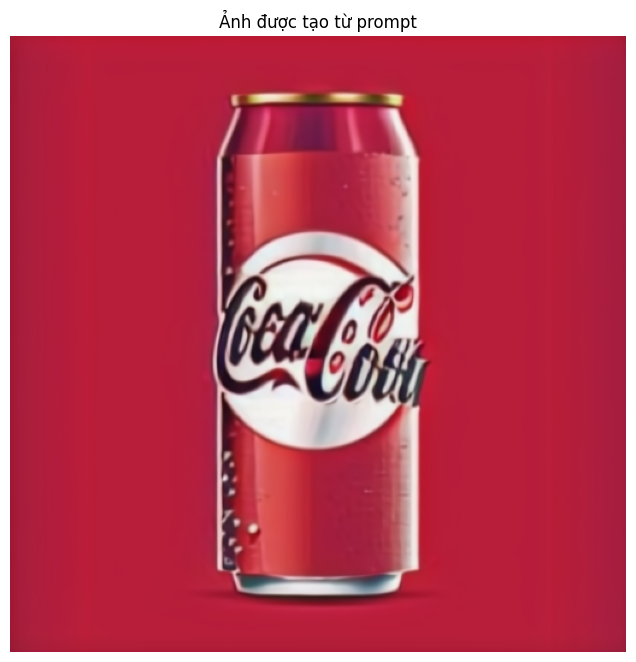

In [ ]:
# Thử nghiệm trên tập test
encoder.load_state_dict(torch.load(os.path.join(MODEL_DIR, "/content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_14.pth")))
decoder.load_state_dict(torch.load(os.path.join(MODEL_DIR, "/content/drive/MyDrive/Computer Vision/Final-CV/models/decoder_finetuned_epoch_14.pth")))
models["encoder"] = encoder
models["decoder"] = decoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Tạo ảnh từ prompt trong tập test
test_prompt = "A Coca soft drink label with red, white colors and classic and bold style, featuring a large white script font for the Coca-Cola logo, small sans-serif text for 'Original Taste', modern design, gradient background, with a centered logo, high quality, ultra-detailed, realistic."  # Lấy prompt đầu tiên từ tập test
output_image = generate(
    prompt=test_prompt,
    uncond_prompt="",
    input_image=None,
    strength=0.8,
    do_cfg=True,
    cfg_scale=25.0,
    sampler_name="ddpm",
    n_inference_steps=50,
    models=models,
    seed=42,
    device=DEVICE,
    idle_device="cpu",
    tokenizer=tokenizer,
)
# output_path = os.path.join(OUTPUT_DIR, "test_finetuned.jpg")
# Image.fromarray(output_image).save(output_path)
# print(f"Đã lưu ảnh thử nghiệm: {output_path}")
# Hiển thị ảnh
plt.figure(figsize=(8, 8))
plt.imshow(output_image)
plt.axis('off')  # Ẩn trục
plt.title("Ảnh được tạo từ prompt")
plt.show()

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


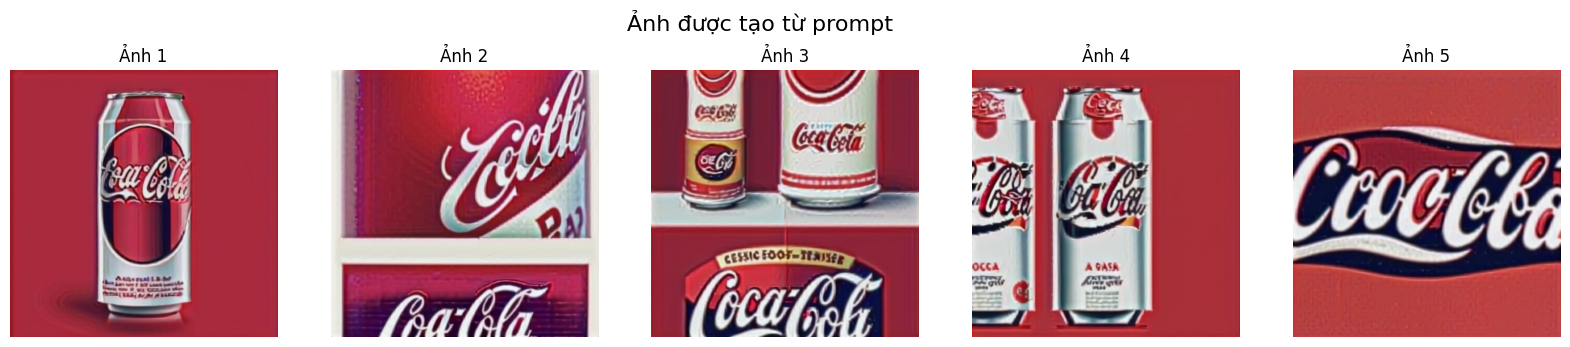

In [ ]:
# Thử nghiệm trên tập test
encoder.load_state_dict(torch.load(os.path.join(MODEL_DIR, "/content/drive/MyDrive/encoder_finetuned_epoch_14.pth")))
decoder.load_state_dict(torch.load(os.path.join(MODEL_DIR, "/content/drive/MyDrive/decoder_finetuned_epoch_14.pth")))
models["encoder"] = encoder
models["decoder"] = decoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Tạo và hiển thị 5 ảnh từ prompt trong tập test
test_prompt = "A Coca soft drink label with red, white colors and classic and bold style, featuring a large white script font for the Coca-Cola logo, small sans-serif text for 'Original Taste', modern design, futuristic font, with a sunburst, high quality, ultra-detailed, realistic."
images = []  # Danh sách để lưu các ảnh

for i in range(5):
    output_image = generate(
        prompt=test_prompt,
        uncond_prompt="",
        input_image=None,
        strength=0.8,
        do_cfg=True,
        cfg_scale=30.0,
        sampler_name="ddpm",
        n_inference_steps=100,
        models=models,
        seed=42 + i,  # Different seeds for variety
        device=DEVICE,
        idle_device="cpu",
        tokenizer=tokenizer
    )
    images.append(output_image)  # Thêm ảnh vào danh sách

# Hiển thị tất cả 5 ảnh trong một lưới
plt.figure(figsize=(20, 4))  # Tạo figure với kích thước lớn
for i in range(5):
    plt.subplot(1, 5, i + 1)  # Tạo subplot 1 hàng, 5 cột
    plt.imshow(images[i])
    plt.axis('off')  # Ẩn trục
    plt.title(f"Ảnh {i + 1}")
plt.suptitle("Ảnh được tạo từ prompt", fontsize=16)
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

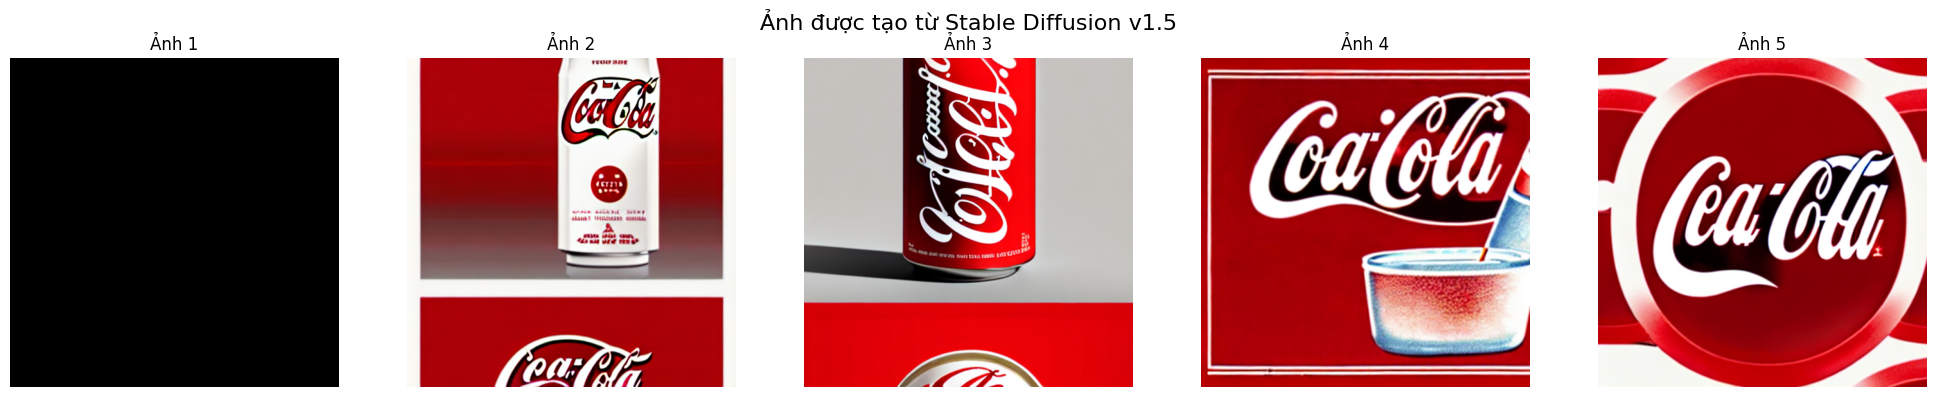

In [ ]:
# Prompt thử nghiệm
test_prompt = "A Coca soft drink label with red, white colors and classic and bold style, featuring a large white script font for the Coca-Cola logo, small sans-serif text for 'Original Taste', modern design, futuristic font, with a sunburst, high quality, ultra-detailed, realistic."

# Tạo 5 ảnh
images = []
for i in range(5):
    image = pipe(
        prompt=test_prompt,
        negative_prompt="",
        num_inference_steps=100,
        guidance_scale=30.0,
        generator=torch.Generator(device=DEVICE).manual_seed(42 + i)
    ).images[0]
    images.append(image)

# Hiển thị ảnh trong lưới
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Ảnh {i + 1}")
plt.suptitle("Ảnh được tạo từ Stable Diffusion v1.5", fontsize=16)
plt.tight_layout()
plt.show()

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


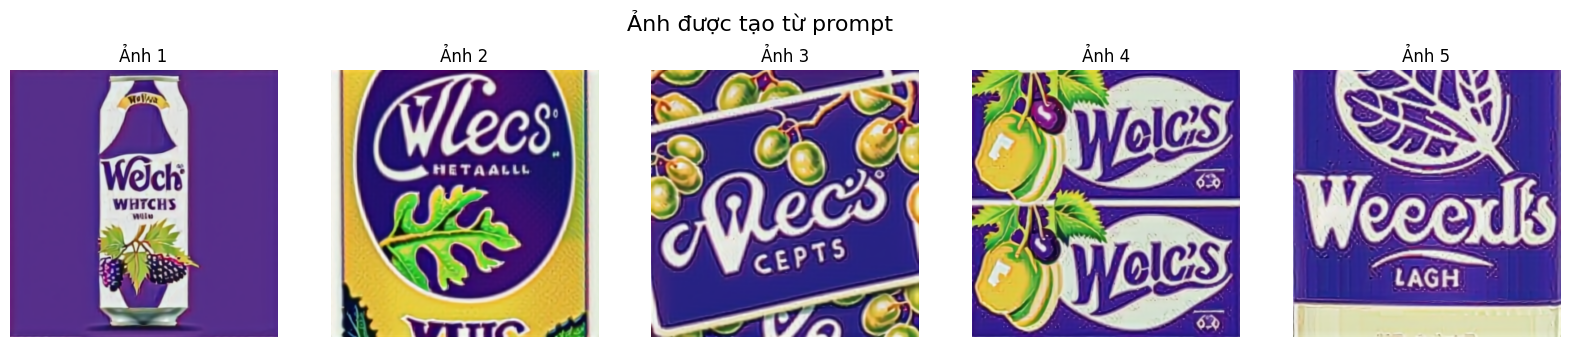

In [ ]:
# Thử nghiệm trên tập test
encoder.load_state_dict(torch.load(os.path.join(MODEL_DIR, "/content/drive/MyDrive/encoder_finetuned_epoch_14.pth")))
decoder.load_state_dict(torch.load(os.path.join(MODEL_DIR, "/content/drive/MyDrive/decoder_finetuned_epoch_14.pth")))
models["encoder"] = encoder
models["decoder"] = decoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Tạo và hiển thị 5 ảnh từ prompt trong tập test
test_prompt = "A Welchs soft drink label with purple, white colors and fruity style, featuring a purple and white logo with a grape cluster, modern design, with a centered logo, with a tropical leaf, high quality, ultra-detailed, realistic."
images = []  # Danh sách để lưu các ảnh

for i in range(5):
    output_image = generate(
        prompt=test_prompt,
        uncond_prompt="",
        input_image=None,
        strength=0.8,
        do_cfg=True,
        cfg_scale=30.0,
        sampler_name="ddpm",
        n_inference_steps=100,
        models=models,
        seed=42 + i,  # Different seeds for variety
        device=DEVICE,
        idle_device="cpu",
        tokenizer=tokenizer
    )
    images.append(output_image)  # Thêm ảnh vào danh sách

# Hiển thị tất cả 5 ảnh trong một lưới
plt.figure(figsize=(20, 4))  # Tạo figure với kích thước lớn
for i in range(5):
    plt.subplot(1, 5, i + 1)  # Tạo subplot 1 hàng, 5 cột
    plt.imshow(images[i])
    plt.axis('off')  # Ẩn trục
    plt.title(f"Ảnh {i + 1}")
plt.suptitle("Ảnh được tạo từ prompt", fontsize=16)
plt.show()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

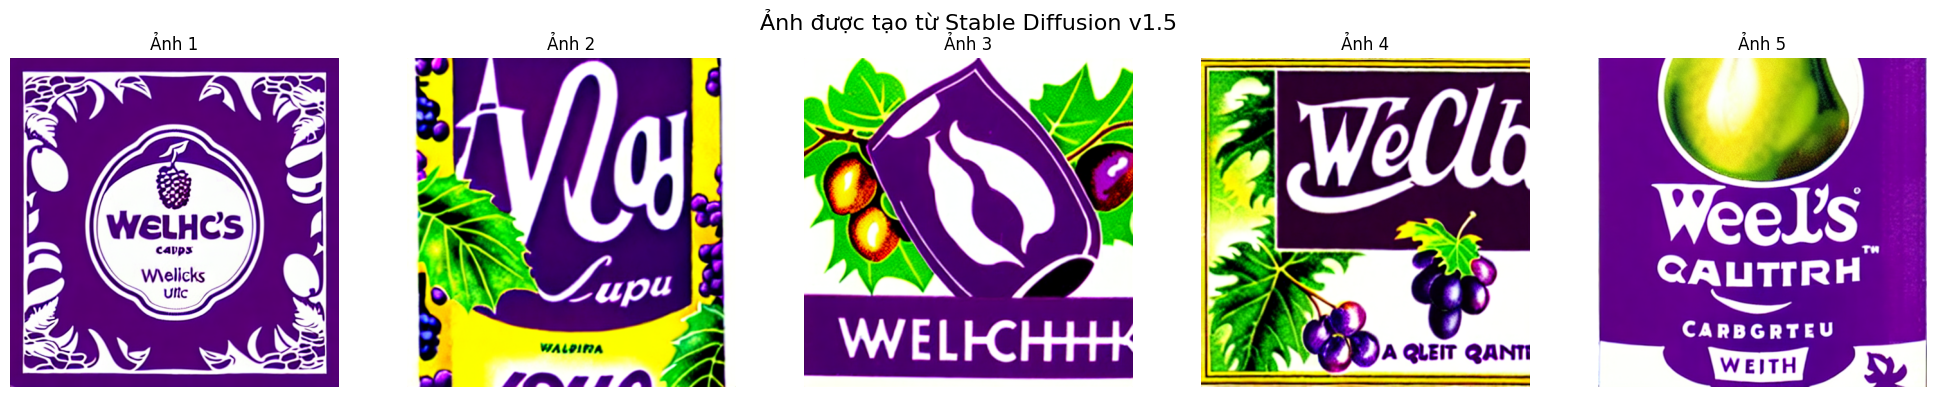

In [ ]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import os

# Định nghĩa thiết bị
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tải mô hình Stable Diffusion v1.5
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to(DEVICE)

# Prompt thử nghiệm
test_prompt = "A Welchs soft drink label with purple, white colors and fruity style, featuring a purple and white logo with a grape cluster, modern design, with a centered logo, with a tropical leaf, high quality, ultra-detailed, realistic."

# Tạo 5 ảnh
images = []
for i in range(5):
    image = pipe(
        prompt=test_prompt,
        negative_prompt="",
        num_inference_steps=100,
        guidance_scale=30.0,
        generator=torch.Generator(device=DEVICE).manual_seed(42 + i)
    ).images[0]
    images.append(image)

# Hiển thị ảnh trong lưới
plt.figure(figsize=(20, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(f"Ảnh {i + 1}")
plt.suptitle("Ảnh được tạo từ Stable Diffusion v1.5", fontsize=16)
plt.tight_layout()
plt.show()

Đã lưu biểu đồ tại: /content/drive/MyDrive/Computer Vision/Final-CV/plots/training_metrics.png


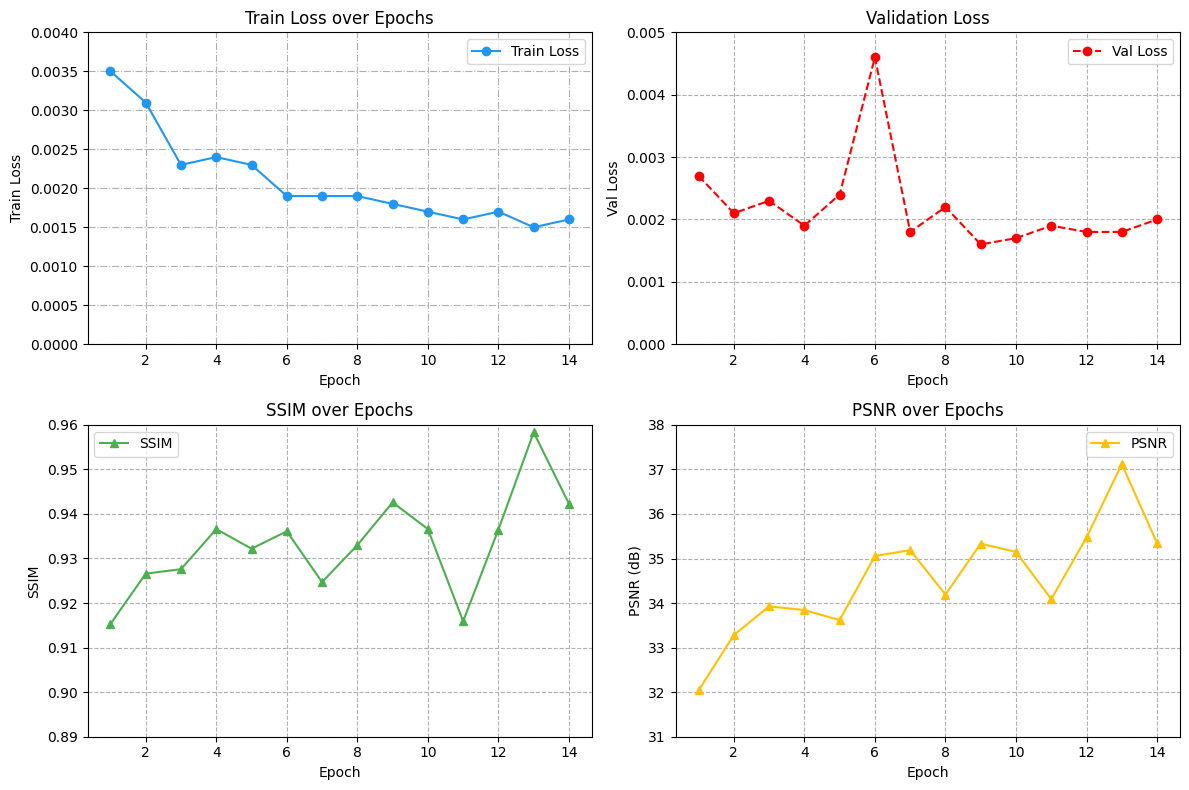

In [ ]:
import matplotlib.pyplot as plt
import os

# Dữ liệu từ các epoch
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
train_loss = [0.0035, 0.0031, 0.0023, 0.0024, 0.0023, 0.0019, 0.0019, 0.0019, 0.0018, 0.0017, 0.0016, 0.0017, 0.0015, 0.0016]
val_loss = [0.0027, 0.0021, 0.0023, 0.0019, 0.0024, 0.0046, 0.0018, 0.0022, 0.0016, 0.0017, 0.0019, 0.0018, 0.0018, 0.0020]
ssim = [0.9153, 0.9266, 0.9276, 0.9366, 0.9322, 0.9361, 0.9247, 0.9330, 0.9426, 0.9366, 0.9159, 0.9365, 0.9583, 0.9423]
psnr = [32.0397, 33.2815, 33.9262, 33.8424, 33.6163, 35.0566, 35.1867, 34.1900, 35.3352, 35.1457, 34.0883, 35.4728, 37.1189, 35.3444]

# Đường dẫn lưu biểu đồ
PLOT_DIR = "/content/drive/MyDrive/Computer Vision/Final-CV/plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Tạo figure với 4 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Plot Train Loss
axes[0, 0].plot(epochs, train_loss, marker='o', color='#2196F3', linestyle='-', markersize=6, label='Train Loss')
axes[0, 0].set_title('Train Loss over Epochs')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Train Loss')
axes[0, 0].grid(True, linestyle='-.')
axes[0, 0].legend()
axes[0, 0].set_ylim([0, 0.004])

# Plot Val Loss
axes[0, 1].plot(epochs, val_loss, '--r', marker='o', markersize=6, label='Val Loss')
axes[0, 1].set_title('Validation Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Val Loss')
axes[0, 1].grid(True, linestyle='--')
axes[0, 1].legend()
axes[0, 1].set_ylim([0, 0.005])

# Plot SSIM
axes[1, 0].plot(epochs, ssim, marker='^', color='#4CAF50', markersize=6, label='SSIM')
axes[1, 0].set_title('SSIM over Epochs')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].grid(True, linestyle='--')
axes[1, 0].legend()
axes[1, 0].set_ylim([0.89, 0.96])

# Plot PSNR
axes[1, 1].plot(epochs, psnr, marker='^', color='#FFC107', markersize=6, label='PSNR')
axes[1, 1].set_title('PSNR over Epochs')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('PSNR (dB)')
axes[1, 1].grid(True, linestyle='--')
axes[1, 1].legend()
axes[1, 1].set_ylim([31, 38])

# Điều chỉnh bố cục để tránh chồng lấn
plt.tight_layout()

# Lưu biểu đồ
save_path = os.path.join(PLOT_DIR, 'training_metrics.png')
plt.savefig(save_path, dpi=300)
print(f"Đã lưu biểu đồ tại: {save_path}")

# Hiển thị biểu đồ
plt.show()